(array([-57.02647348, 264.45553715]), array([[  8.51079581, -30.00103635],
       [-30.00103635, 112.65656862]]))


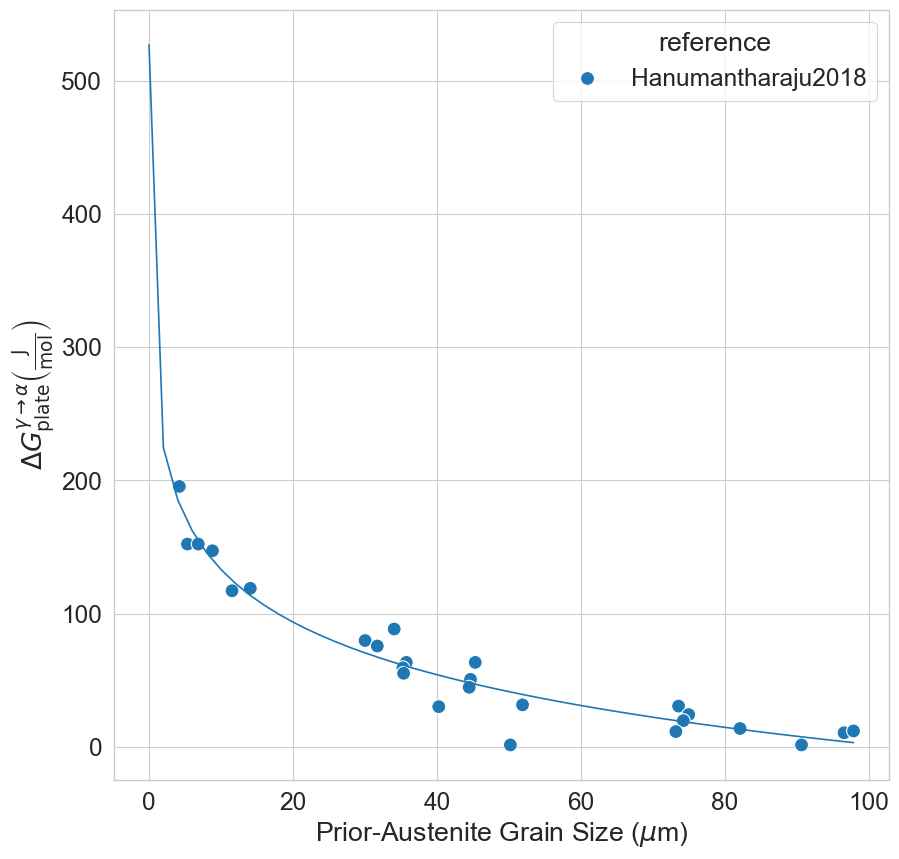

In [19]:
"""
Code for fitting the prior-austenite grain size effects on the martensite driving force.
Currently including driving-force calculations from Hanumantharaju and Kumar [1] for the time being.

References : [1] G. Hanumantharaju and A. Kumar, “Thermodynamic modeling of martensite start 
                    temperature in commercial steels,” KTH, School of Industrial Engineering and Management, 2018.
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)

def plate_fit(x, a, b):
    return a*np.log(x) + b

exp_data_dir = './experimental_data'
model_param_dir = './model_params'
figure_dir = './figures'
pred_data = pd.read_json('/'.join([exp_data_dir, 'predicted_martensite_start.json']))
fig_query = pred_data.query("~PAGS.isnull() & type == 'plate' & predicted_type == False").sort_values('error', ascending=False).copy()
fig_query['offset_DG'] = 0.0

fig,ax = plt.subplots(figsize=(10,10))
for reference in fig_query['reference'].unique():
    fig_sub_query = fig_query.query("reference == @reference").copy()
    if len(fig_sub_query) > 1:
        fig_sub_query['offset_DG'] = fig_sub_query['DG_no_PAGS'] - np.min(fig_sub_query['DG_no_PAGS'])
        fig_query.loc[fig_sub_query.index, 'offset_DG'] = fig_sub_query['offset_DG']
    else:
        fig_query = fig_query.drop(index=fig_sub_query.index)
    
han_data = pd.read_excel('/'.join([exp_data_dir, 'Hanumantharaju2018-PAGS.xlsx']))  # Include the data from [1] for now
han_data['offset_DG'] = han_data['DG']
fig_query  = pd.concat([fig_query, han_data]).query("type == 'plate'").reset_index(drop=True)

sns.scatterplot(data=fig_query, x='PAGS', y='offset_DG', hue='reference', ax=ax, s=100)
fits = curve_fit(plate_fit, fig_query['PAGS'], fig_query['offset_DG'], bounds=(-100, np.inf))
x_vals = np.linspace(1e-2, np.max(fig_query['PAGS']))
y_vals = [plate_fit(x, *fits[0]) for x in x_vals]
ax.plot(x_vals, y_vals)

ax.set_xlabel(r'Prior-Austenite Grain Size ($\mu$m)')
ax.set_ylabel(r'$\Delta G ^{\gamma \rightarrow \alpha}_\mathrm{plate} \left( \frac{\mathrm{J}}{\mathrm{mol}} \right)$')
fig.savefig('/'.join([figure_dir, 'mf-plate_pags_model.png']))
print(fits)


(array([ -6.91419073,   9.49295022, 301.84731367]), array([[ 3.43291088e+15,  4.71327061e+15, -1.92703435e+08],
       [ 4.71327061e+15,  6.47116125e+15, -2.64575280e+08],
       [-1.92703435e+08, -2.64575280e+08,  4.59172236e+02]]))


<Axes: xlabel='PAGS', ylabel='DG'>

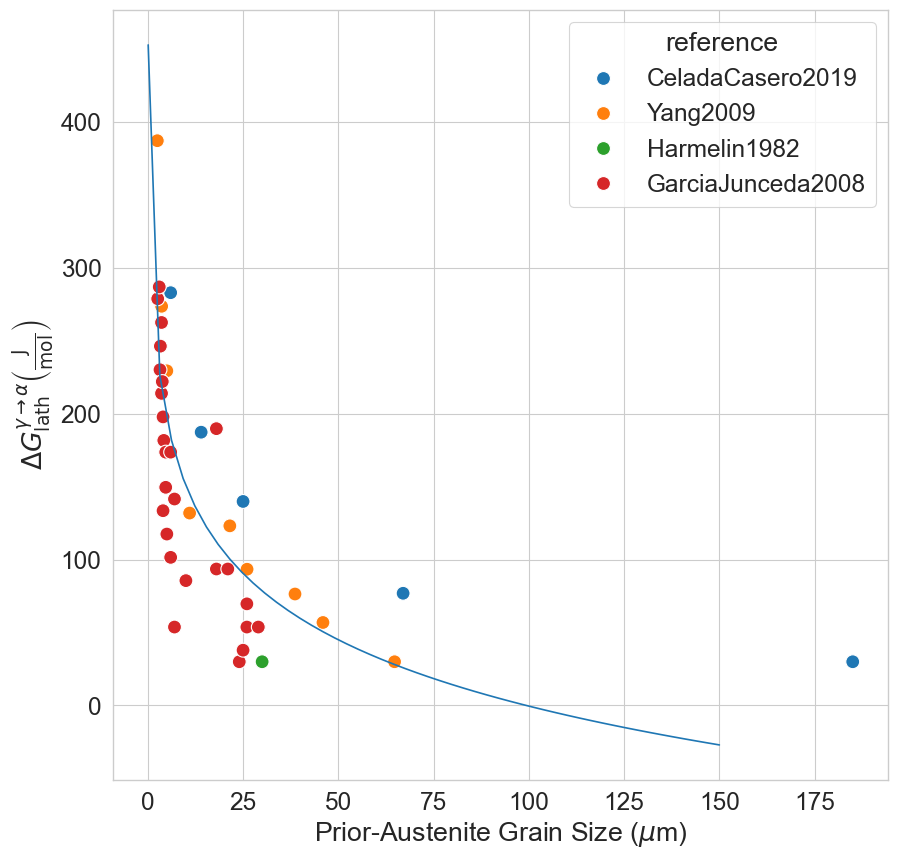

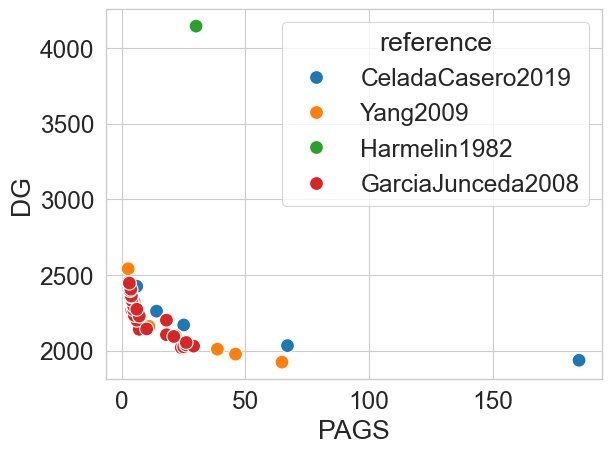

In [18]:
"""
Code for fitting PAGS effects on the driving force for formation of lath martensite.
There's a semi-arbitrary offset to make the model predict a PAGS energy of ~0 J/mol at a grain size of 100 microns.
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)

def lath_fit(x, a, b, c):
    return a*np.log(x**b) + c

exp_data_dir = './experimental_data'
model_param_dir = './model_params'
figure_dir = './figures'
pred_data = pd.read_json('/'.join([exp_data_dir, 'predicted_martensite_start.json']))
fig_query = pred_data.query("~PAGS.isnull() & type == 'lath' & predicted_type == False").sort_values('error', ascending=False).copy()
fig_query['offset_DG'] = 0.0
ignored_references = ['Harmelin1982']

fig,ax = plt.subplots(figsize=(10,10))
for reference in fig_query['reference'].unique():
    if reference in  ignored_references:
        continue
    fig_sub_query = fig_query.query("reference == @reference").copy()
    fig_sub_query['offset_DG'] = fig_sub_query['DG_no_PAGS'] - np.min(fig_sub_query['DG_no_PAGS'])
    fig_query.loc[fig_sub_query.index, 'offset_DG'] = fig_sub_query['offset_DG']
fig_query = fig_query.query("offset_DG < 400").copy()
fig_query['offset_DG'] = fig_query['offset_DG'] + 30  # 30 J/mol offset to make 100 microns ~ 0 J/mol
sns.scatterplot(data=fig_query, x='PAGS', y='offset_DG', hue='reference', ax=ax, s=100)
fits = curve_fit(lath_fit, fig_query['PAGS'], fig_query['offset_DG'], bounds=(-50, np.inf))
x_vals = np.linspace(1e-1, 150)
y_vals = [lath_fit(x, *fits[0]) for x in x_vals]
ax.plot(x_vals, y_vals)

ax.set_xlabel(r'Prior-Austenite Grain Size ($\mu$m)')
ax.set_ylabel(r'$\Delta G ^{\gamma \rightarrow \alpha}_\mathrm{lath} \left( \frac{\mathrm{J}}{\mathrm{mol}} \right)$')
fig.savefig('/'.join([figure_dir, 'mf-lath_pags_model.png']))
print(fits)

fig,ax = plt.subplots()
sns.scatterplot(data=fig_query, x='PAGS', y='DG', hue='reference', s=100)

[ 7.17987277e+01  3.14716030e-06 -1.71695704e-01 -4.79208177e+02]


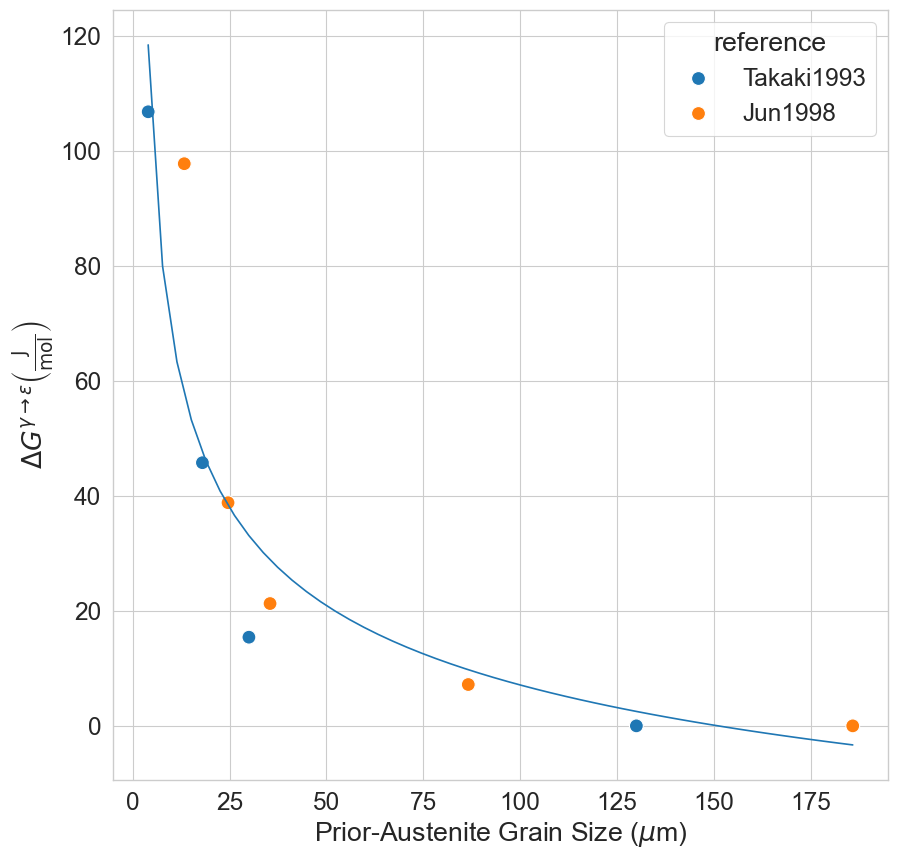

In [20]:
# PAGS model for epsilon
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)

def eps_fit(x, a, b, c, d):
    return a*np.log(x**b)**c + d

exp_data_dir = './experimental_data'
model_param_dir = './model_params'
figure_dir = './figures'
pred_data = pd.read_json('/'.join([exp_data_dir, 'predicted_martensite_start.json']))
fig_query = pred_data.query("~PAGS.isnull() & type == 'epsilon' & predicted_type == False").sort_values('error', ascending=False).copy()
fig_query['offset_DG'] = 0.0
fig,ax = plt.subplots(figsize=(10,10))
for reference in fig_query['reference'].unique():
    fig_sub_query = fig_query.query("reference == @reference").copy()
    fig_sub_query['offset_DG'] = fig_sub_query['DG_no_PAGS'] - np.min(fig_sub_query['DG_no_PAGS'])
    fig_query.loc[fig_sub_query.index, 'offset_DG'] = fig_sub_query['offset_DG']
sns.scatterplot(data=fig_query, x='PAGS', y='offset_DG', hue='reference', ax=ax, s=100)
fits = curve_fit(eps_fit, fig_query['PAGS'], fig_query['offset_DG'])
x_vals = np.linspace(np.min(fig_query['PAGS']), np.max(fig_query['PAGS']))
y_vals = [eps_fit(x, *fits[0]) for x in x_vals]
ax.plot(x_vals, y_vals)

ax.set_xlabel(r'Prior-Austenite Grain Size ($\mu$m)')
ax.set_ylabel(r'$\Delta G ^{\gamma \rightarrow \epsilon} \left( \frac{\mathrm{J}}{\mathrm{mol}} \right)$')
fig.savefig('/'.join([figure_dir, 'mf-epsilon_pags_model.png']))
print(fits[0])
